In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')


# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
# Load in the train and test datasets
dataset_train = pd.read_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Data_Train.xlsx')
dataset_test = pd.read_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Data_Test.xlsx')
sample = pd.read_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Sample_Submission.xlsx')

In [3]:
time_list = dataset_train.Delivery_Time.unique()

In [4]:
dataset_train.Cuisines.nunique()

2179

In [5]:
def get_time(data):
    reserve = data.split()
    return reserve[0]

In [6]:
def get_avg_cost(data):
    reserve = data[1:]
    return reserve

In [7]:
dataset_train['avg_cost'] = dataset_train.Average_Cost.apply(get_avg_cost)
dataset_test['avg_cost'] = dataset_test.Average_Cost.apply(get_avg_cost)
dataset_train['min_order'] = dataset_train.Minimum_Order.apply(get_avg_cost)
dataset_test['min_order'] = dataset_test.Minimum_Order.apply(get_avg_cost)

In [8]:
dataset_train['Del_Time'] = dataset_train['Delivery_Time'].map( {'10 minutes': 0, '20 minutes': 1, '30 minutes': 2, '45 minutes':3, '65 minutes':4, '80 minutes':5 ,'120 minutes':6} ).astype(int)

In [9]:
i_cols = ['Average_Cost','Minimum_Order','Delivery_Time']

In [10]:
train = dataset_train.drop(i_cols,axis=1)
test = dataset_test.drop(['Average_Cost','Minimum_Order'],axis=1)

In [11]:
import re


def delete_comma(data):
    rev = str(data).split(",")
    try:
        complex(data) # for int, long, float and complex
        return data
    except ValueError:
        new_string = ''.join(re.findall(r'\d+', data))
        if new_string.isnumeric():
            return int(new_string)
        else:
            return 0
   

In [12]:
train['avg_cost'] = train['avg_cost'].apply(delete_comma)
test['avg_cost'] = test['avg_cost'].apply(delete_comma)
train['min_order'] = train['min_order'].apply(delete_comma)
test['min_order'] = test['min_order'].apply(delete_comma)

In [13]:
train['avg_cost'] = train['avg_cost'].astype(float)
test['avg_cost'] = test['avg_cost'].astype(float)
train['min_order'] = train['min_order'].astype(float)
test['min_order'] = test['min_order'].astype(float)

In [14]:
def make_digit(data):
    if data == 'Opening Soon' or data =='Temporarily Closed':
        return 0
    elif data == 'NEW':
        return 2.5
    elif data == '-':
        return 2.5
    else:
        return data

In [15]:
train['Rating'] = train['Rating'].apply(make_digit)
test['Rating'] = test['Rating'].apply(make_digit)
train['Rating'] = train['Rating'].astype(float)
test['Rating'] = test['Rating'].astype(float)

In [18]:
y_train = train['Del_Time']
X_train = train.drop(['Del_Time'],axis=1)
X_test = test.copy()

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [20]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['mean'])['mean'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_st'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_st'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_st, ',end='')

Restaurant_Votes_st, 

In [21]:
comb = pd.concat([X_train[['Restaurant']+['Reviews']],X_test[['Restaurant']+['Reviews']]],axis=0)
mp = comb.groupby('Restaurant')['Reviews'].agg(['mean'])['mean'].to_dict()
X_train['Restaurant'+'_'+'Reviews'+'_st'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Reviews'+'_st'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Reviews'+'_st, ',end='')

Restaurant_Reviews_st, 

In [22]:
comb = pd.concat([X_train[['Restaurant']+['Reviews']],X_test[['Restaurant']+['Reviews']]],axis=0)
mp = comb.groupby('Restaurant')['Reviews'].agg(['cumsum'])['cumsum'].to_dict()
X_train['Restaurant'+'_'+'Reviews'+'_cs'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Reviews'+'_cs'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Reviews'+'_cs, ',end='')

Restaurant_Reviews_cs, 

In [23]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['cumsum'])['cumsum'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_cs'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_cs'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_cs, ',end='')

Restaurant_Votes_cs, 

In [24]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['std'])['std'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_std'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_std'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_std, ',end='')

Restaurant_Votes_std, 

In [25]:
comb = pd.concat([X_train[['Restaurant']+['Reviews']],X_test[['Restaurant']+['Reviews']]],axis=0)
mp = comb.groupby('Restaurant')['Reviews'].agg(['cummax'])['cummax'].to_dict()
X_train['Restaurant'+'_'+'Reviews'+'_cm'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Reviews'+'_cm'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Reviews'+'_cm, ',end='')

Restaurant_Reviews_cm, 

In [26]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['cummax'])['cummax'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_cm'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_cm'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_cm, ',end='')

Restaurant_Votes_cm, 

In [27]:
X_train['Reviews_count_full'] = X_train['Reviews'].map(pd.concat([X_train['Reviews'], X_test['Reviews']], ignore_index=True).value_counts(dropna=False))
X_test['Reviews_count_full'] = X_test['Reviews'].map(pd.concat([X_train['Reviews'], X_test['Reviews']], ignore_index=True).value_counts(dropna=False))

In [31]:
concatenated = pd.concat([X_train,X_test],axis=0)

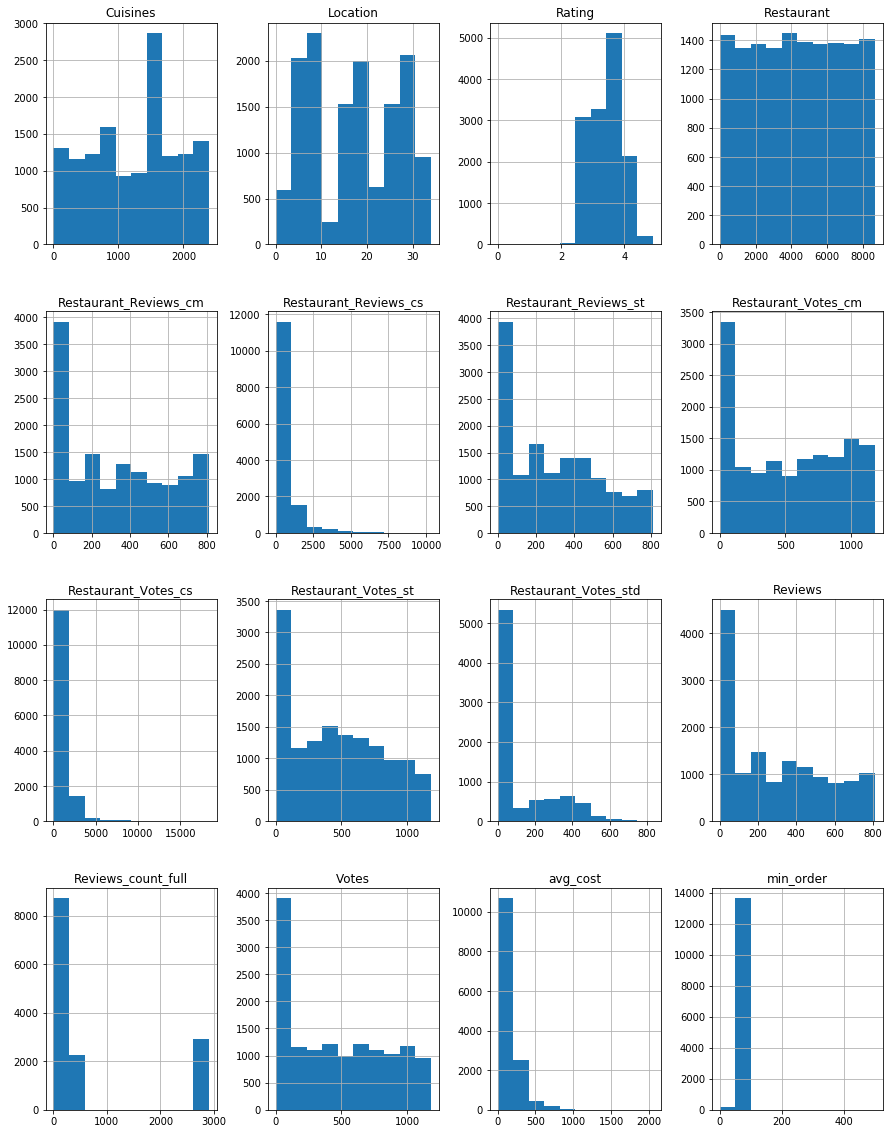

<Figure size 432x288 with 0 Axes>

In [32]:
concatenated.hist(figsize=(15,20));
plt.figure();

In [30]:
X_train.min_order.unique()

array([ 50.,  99.,   0., 200., 450., 350.,  79., 400., 199., 500., 250.,
       150.,  90., 299., 300., 240.,  89.,  59.])

In [35]:
print(np.count_nonzero(concatenated['min_order'] > 200))

16


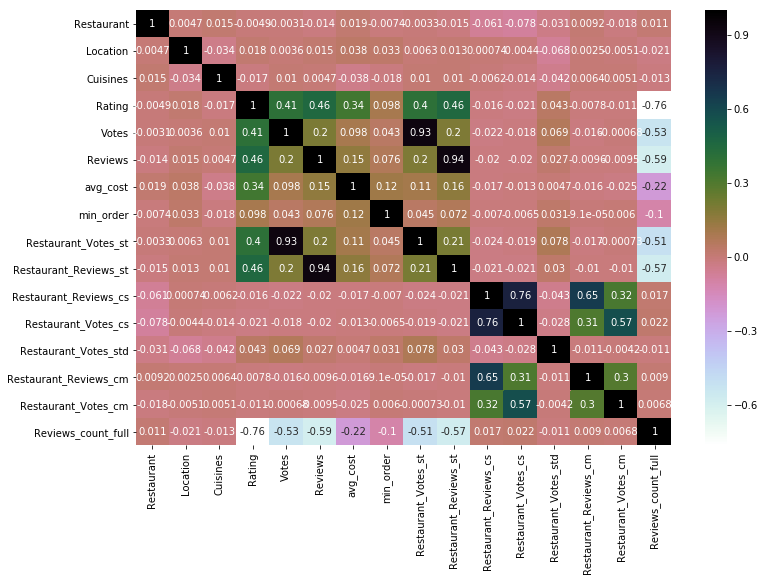

In [37]:
plt.figure(figsize=(12,8)) 
sns.heatmap(concatenated.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted by(iris.corr())
plt.show();

In [38]:
X_train['y'] = y_train

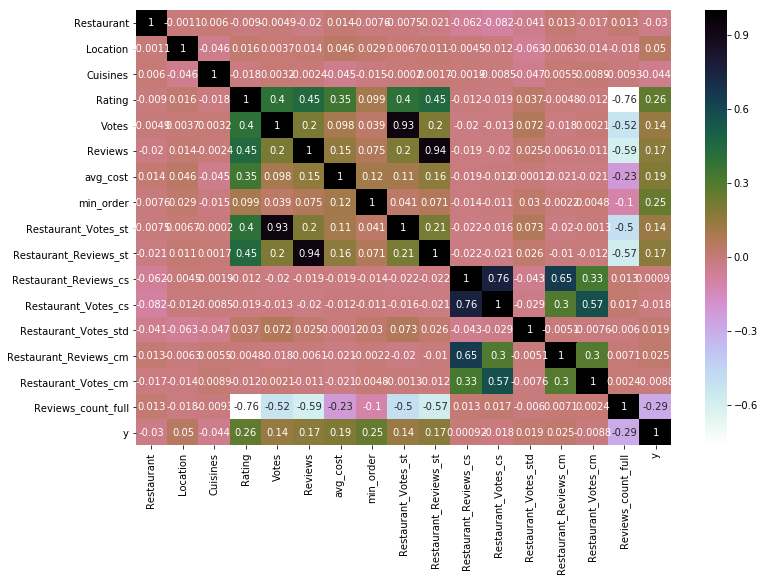

In [39]:
plt.figure(figsize=(12,8)) 
sns.heatmap(X_train.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted by(iris.corr())
plt.show();

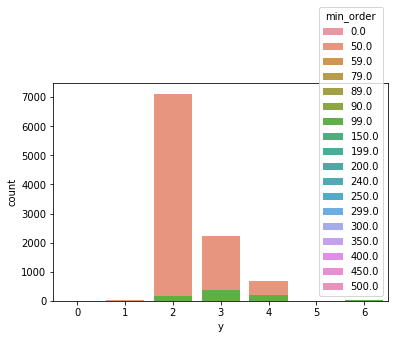

In [46]:
ax = sns.countplot(x="y", hue="min_order", data=X_train,dodge =False)

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

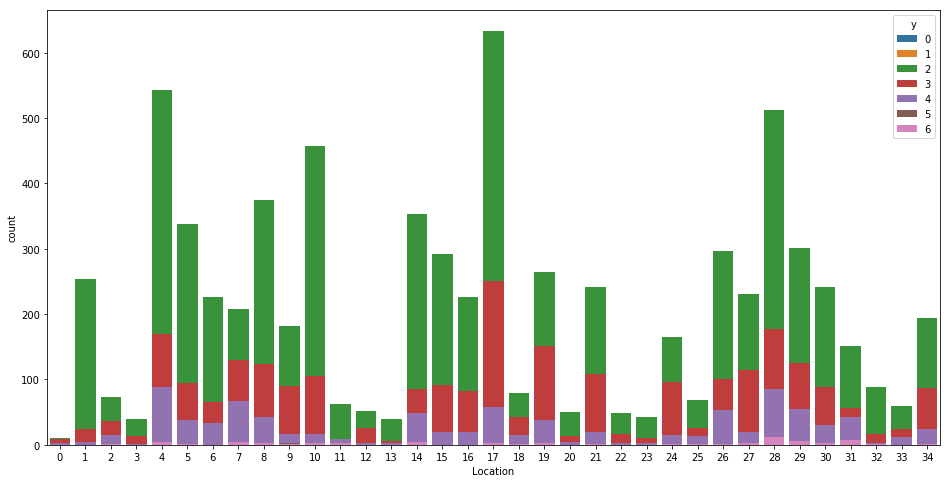

In [56]:
plt.figure(figsize=(16, 8))
sns.countplot(x="Location", hue="y", data=X_train,dodge =False)

In [55]:
print(np.count_nonzero(X_train['Location']==0))

22


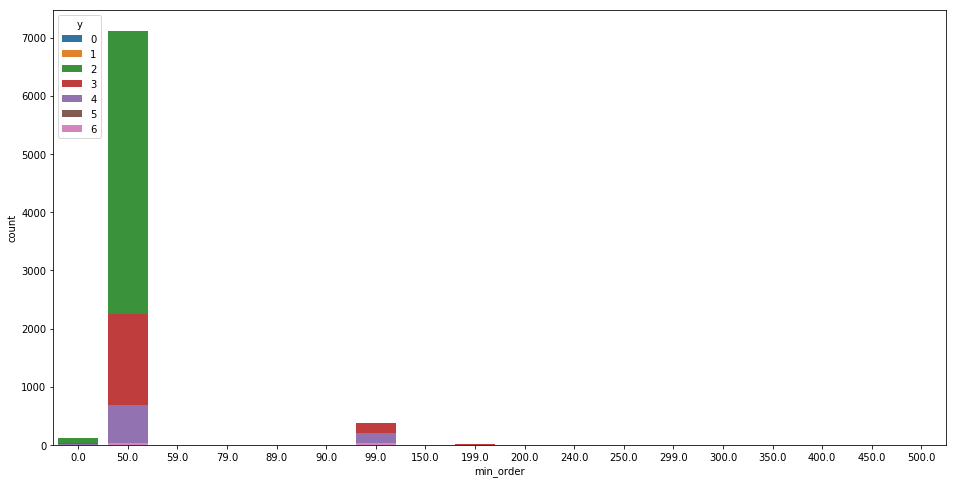

In [58]:
plt.figure(figsize=(16, 8))
sns.countplot(x="min_order", hue="y", data=X_train,dodge =False)

In [60]:
print(np.count_nonzero(X_train['min_order'] > 100))
print(np.count_nonzero(X_test['min_order'] > 100))

31
10


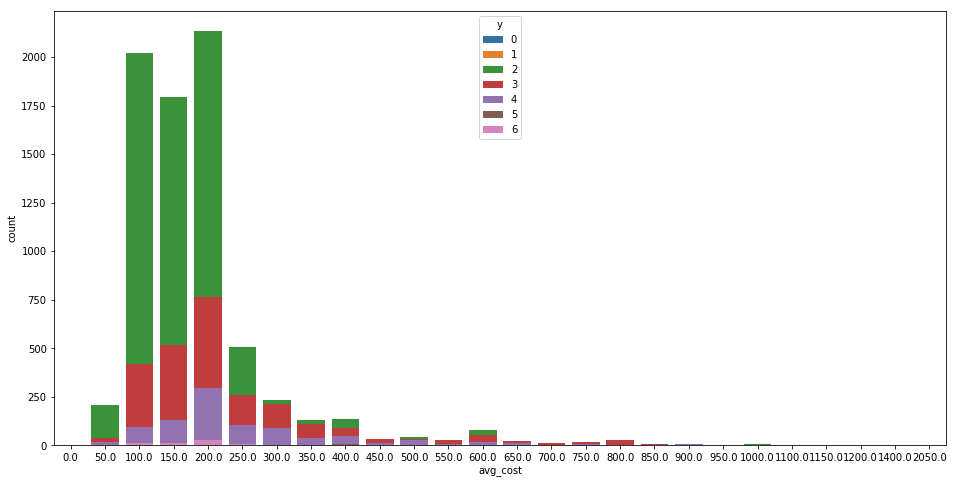

In [61]:
plt.figure(figsize=(16, 8))
sns.countplot(x="avg_cost", hue="y", data=X_train,dodge =False)